[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mlexchange/als_ml_tutorial/blob/main/4_2_ML_tutorial_cnn.ipynb)

## 4.2 Convolutional Autoencoders

### 4.2.1 Network architecture

In [1]:
from torch.nn import Module, Sequential
from torch.nn import Conv2d, ReLU, MaxPool2d, ConvTranspose2d, Sigmoid, Flatten, Unflatten, Linear

class CNN(Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.encoder = Sequential(
            Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2),
            Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2),
            Flatten(),
            Linear(64* (input_shape[1] // 4) * (input_shape[2] // 4), latent_dim)
        )
        self.decoder = Sequential(
            Linear(latent_dim, 64 * (input_shape[1] // 4) * (input_shape[2] // 4)),
            Unflatten(1, (64, input_shape[1] // 4, input_shape[2] // 4)),
            ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, 
                            output_padding=1),
            ReLU(),
            ConvTranspose2d(in_channels=32, out_channels=input_shape[0], kernel_size=3, stride=2, 
                            padding=1, output_padding=1),
            Sigmoid()
        )
    
    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return z

#### Let's check our architecture closely

In [2]:
from torchsummary import summary

auto_cnn = CNN(input_shape=(1, 128, 128), latent_dim=1000)

summary(auto_cnn, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
           Flatten-7                [-1, 65536]               0
            Linear-8                 [-1, 1000]      65,537,000
            Linear-9                [-1, 65536]      65,601,536
        Unflatten-10           [-1, 64, 32, 32]               0
  ConvTranspose2d-11           [-1, 32, 64, 64]          18,464
             ReLU-12           [-1, 32, 64, 64]               0
  ConvTranspose2d-13          [-1, 1, 128, 128]             289
          Sigmoid-14          [-1, 1, 1

### 4.2.2 Data Preparation

Let's prepare our training and validation sets

In [3]:
import os
from torch.utils.data import Dataset
from PIL import Image

class FileDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.image_paths = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) 
                            if not filename.startswith('.')]
        self.transform = transform
    
    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        if self.transform:
            image = self.transform(image)
        return image
    
    def __len__(self):
        return len(self.image_paths)

#### Let's add the path to the data set

In [4]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

data_dir = '/path/to/data'                  # Add the path to the data
data_transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = FileDataset(data_dir, transform=data_transform)

# Split the dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### 4.2.3 Model Training

In [5]:
import torch
from torch.nn import MSELoss
from torch.optim import AdamW

# Training parameters
criterion = MSELoss()
optimizer = AdamW(auto_cnn.parameters(), lr=0.001)   #0.005
num_epochs = 50     #20

epoch_loss = []
epoch_val_loss = []
for epoch in range(num_epochs):
    auto_cnn.train()                        # Set the model to training mode
    for input_batch in train_loader:
        optimizer.zero_grad()               # Zero the gradients
        out_batch = auto_cnn(input_batch)          # Forward pass
        loss = criterion(out_batch, input_batch)   # Compute loss
        loss.backward()                     # Backpropagation
        optimizer.step()                    # Update weights
    auto_cnn.eval()                         # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():                   # Validation
        for val_batch in val_loader:
            out_val_batch = auto_cnn(val_batch)
            val_batch_loss = criterion(out_val_batch, val_batch)
            val_loss += val_batch_loss.item()
    avg_val_loss = val_loss / len(val_loader)
    epoch_loss.append(loss.detach().numpy())
    epoch_val_loss.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}, Validation Loss: {avg_val_loss:.6f}')

# Save model
torch.save(auto_cnn.state_dict(), 'trained_model.pth')

Epoch [1/50], Loss: 0.038603, Validation Loss: 0.037995
Epoch [2/50], Loss: 0.027776, Validation Loss: 0.023889
Epoch [3/50], Loss: 0.016191, Validation Loss: 0.017334
Epoch [4/50], Loss: 0.012581, Validation Loss: 0.013283
Epoch [5/50], Loss: 0.011606, Validation Loss: 0.011840
Epoch [6/50], Loss: 0.009757, Validation Loss: 0.010339
Epoch [7/50], Loss: 0.007119, Validation Loss: 0.009550
Epoch [8/50], Loss: 0.008005, Validation Loss: 0.009662
Epoch [9/50], Loss: 0.007391, Validation Loss: 0.008224
Epoch [10/50], Loss: 0.007620, Validation Loss: 0.007757
Epoch [11/50], Loss: 0.005516, Validation Loss: 0.007241
Epoch [12/50], Loss: 0.005639, Validation Loss: 0.006882
Epoch [13/50], Loss: 0.005355, Validation Loss: 0.006466
Epoch [14/50], Loss: 0.004116, Validation Loss: 0.006063
Epoch [15/50], Loss: 0.005308, Validation Loss: 0.005924
Epoch [16/50], Loss: 0.004091, Validation Loss: 0.005693
Epoch [17/50], Loss: 0.004001, Validation Loss: 0.005314
Epoch [18/50], Loss: 0.003441, Validatio

#### Let's check the loss plot

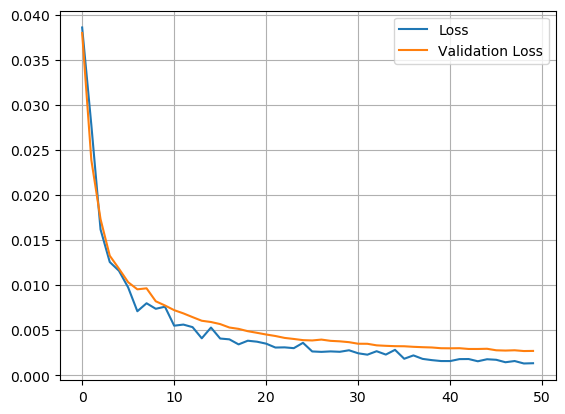

In [6]:
import matplotlib.pyplot as plt

plt.plot(epoch_loss)
plt.plot(epoch_val_loss)
plt.legend(["Loss", "Validation Loss"])
plt.grid()

### 4.2.4 Evaluation

In [7]:
import numpy as np
import random

out_val = []
with torch.no_grad(): 
    for batch in val_loader:
        out_val.append(auto_cnn(batch).detach().cpu().numpy())
reconstructed_set = np.vstack(out_val)

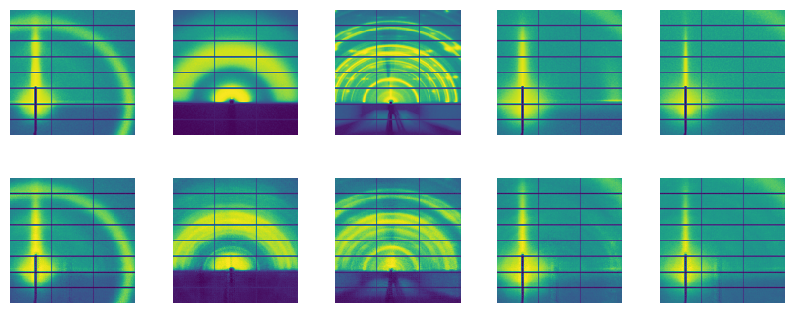

In [39]:
val_set = np.vstack(list(iter(val_loader)))

# Randomly selectes 5 images from the validation set
indxs = random.sample(range(len(reconstructed_set)), 5)

fig, axs = plt.subplots(2, 5, figsize=(10,4))
for i in range(5):
    original_img = val_set[indxs[i]]
    reconstructed_img = reconstructed_set[indxs[i]]
    axs[0, i].imshow(np.squeeze(original_img))
    axs[0, i].axis('off')
    axs[1, i].imshow(np.squeeze(reconstructed_img))
    axs[1, i].axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.2)